In [2]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import re
import pickle
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import sklearn.metrics as metrics
from pandas.api.types import CategoricalDtype
import xgboost as xgb
from skopt import BayesSearchCV


In [63]:
BASE_PATH = "../data"
RAW_DATA_PATH = f"{BASE_PATH}/raw"
TMP_PATH = f"{BASE_PATH}/tmp"
FILE_PATTERN = RAW_DATA_PATH + "/*/OD*"
STATION_PATTERN = RAW_DATA_PATH + "/*/Stations*"
START_STATION = 6184
END_STATION = 6015
START_DATE = "2014-04-15"
END_DATE = "2017-11-15"
THOUSANDS_SYMBOL = " (000s)"
USE_CACHE = True
NUM_CLUSTER = 12
MINIMUM_TRIPS_PAIRWISE = 800
FORECAST_START = "2017-09-04"
FORECAST_END = "2017-09-10"
ITERATIONS = 1 # 1000


In [4]:
def load_data(path_pattern: str, parse_dates=False) -> pd.DataFrame:
    filepath = [pd.read_csv(name, parse_dates=parse_dates) for name in glob.glob(path_pattern)]
    df = pd.concat(filepath)
    return df

In [5]:
df = load_data(FILE_PATTERN, parse_dates=["start_date", "end_date"])
df = df.loc[
        (df.start_date >= START_DATE) &
        (df.end_date < END_DATE)
    ].reset_index(drop=True)

In [6]:
stations = pd.read_csv(f"{TMP_PATH}/clean_stations.csv")
cluster = pd.read_csv(f"{TMP_PATH}/station_cluster.csv")

In [7]:
stations = stations.merge(cluster, on="code")
stations.rename({"code": "start_station_code"}, axis=1, inplace=True)
stations.head()

,start_station_code,name,latitude,longitude,cluster
0,6436,Côte St-Antoine / Clarke,45.486452,-73.595234,4
1,6214,Square St-Louis,45.517350,-73.569060,1
2,6248,St-Dominique / Rachel,45.518593,-73.581566,1
3,6149,Chapleau / du Mont-Royal,45.538670,-73.569360,9
4,6252,Mozart / St-Laurent,45.533180,-73.615440,2


In [8]:
combined_df = df.merge(stations[["start_station_code", "latitude", "longitude", "cluster"]], on="start_station_code", how="inner")

In [9]:
combined_df.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude,longitude,cluster
0,2014-08-01 00:00:00,6215,2014-08-01 00:11:00,6151,702,0,45.514914,-73.578243,1
1,2014-08-01 00:03:00,6215,2014-08-01 00:16:00,6152,800,1,45.514914,-73.578243,1
2,2014-08-01 00:09:00,6215,2014-08-01 00:12:00,6181,178,1,45.514914,-73.578243,1
3,2014-08-01 06:15:00,6215,2014-08-01 06:19:00,6221,233,1,45.514914,-73.578243,1
4,2014-08-01 06:49:00,6215,2014-08-01 06:57:00,6065,512,1,45.514914,-73.578243,1


In [10]:
combined_df.shape

(14806753, 9)

In [11]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

# baseline model
Create baseline model: train only on the data for station 6184 and 6015. <br>
The data is a bit too noisy on one station, but we can still train the model on seasonal features, i.e., year, month, dayofweek etc.

In [12]:
baseline_df = combined_df.loc[(combined_df.start_station_code == START_STATION) & (combined_df.end_station_code == END_STATION)].copy()

In [13]:
baseline_df.set_index("start_date", inplace=True)

In [14]:
baseline_df = baseline_df[["is_member"]].resample("D").count()

In [15]:
baseline_df = baseline_df.loc[
    (baseline_df.index.month.isin([5,6,7,8,9,10]))
]

There is not much autocorrelation betwen lags

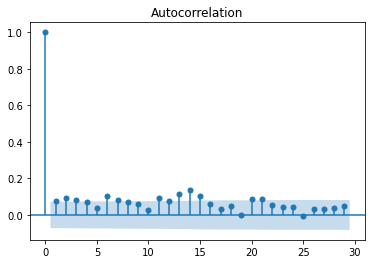

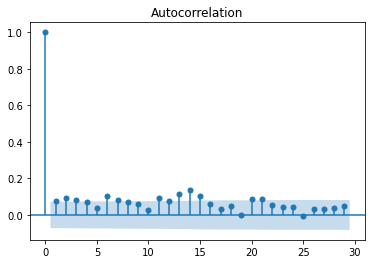

In [16]:
baseline_df.columns = ["trips"]
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(baseline_df.trips)

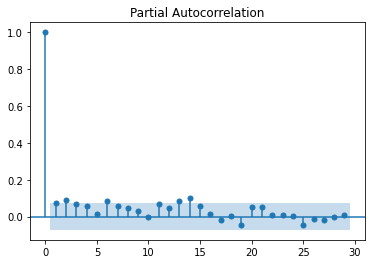

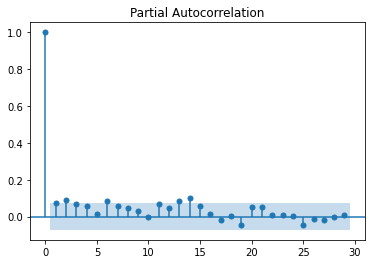

In [17]:
plot_pacf(baseline_df.trips)

In [18]:
baseline_df.loc[:, "month"] = baseline_df.index.month.astype("category")
baseline_df.loc[:, "year"] = baseline_df.index.year.astype("category")
baseline_df.loc[:, "day_of_week"] = baseline_df.index.day_of_week.astype("category")
baseline_df = baseline_df.dropna()
baseline_df = pd.get_dummies(baseline_df)

In [19]:
len(baseline_df)

736

In [20]:
baseline_df.head()

,trips,month_5,month_6,month_7,month_8,month_9,month_10,year_2014,year_2015,year_2016,year_2017,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
start_date,,,,,,,,,,,,,,,,,,
2014-05-01,2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2014-05-02,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2014-05-03,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2014-05-04,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2014-05-05,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0


In [21]:
X_train = baseline_df.loc[:'2017-08-31'].drop(['trips'], axis = 1)
y_train = baseline_df.loc[:'2017-08-31', 'trips']
X_test = baseline_df.loc[FORECAST_START:FORECAST_END].drop(['trips'], axis = 1)
y_test = baseline_df.loc[FORECAST_START:FORECAST_END, 'trips']

Skipping CV for the baseline model

In [22]:
model = Ridge(alpha=1)
model.fit(X_train, y_train)
y_true = y_test.values
y_pred = model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.0665
mean_squared_log_error:  0.6529
r2:  -0.0217
MAE:  2.0288
MSE:  4.9207
RMSE:  2.2183


# Pipeline Session

In [78]:
clean_df = combined_df.copy()
clean_df.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude,longitude,cluster
0,2014-08-01 00:00:00,6215,2014-08-01 00:11:00,6151,702,0,45.514914,-73.578243,1
1,2014-08-01 00:03:00,6215,2014-08-01 00:16:00,6152,800,1,45.514914,-73.578243,1
2,2014-08-01 00:09:00,6215,2014-08-01 00:12:00,6181,178,1,45.514914,-73.578243,1
3,2014-08-01 06:15:00,6215,2014-08-01 06:19:00,6221,233,1,45.514914,-73.578243,1
4,2014-08-01 06:49:00,6215,2014-08-01 06:57:00,6065,512,1,45.514914,-73.578243,1


**Data Cleaning**: since our training unit should be number of trips between pairwise-stations per day, need to do some basic transform


In [79]:
clean_df["start_date"] = clean_df["start_date"].dt.normalize()
clean_df.drop(["end_date"], axis=1, inplace=True)
clean_df = clean_df.groupby(["start_date", "start_station_code", "end_station_code"]).agg(
    {
        "duration_sec": np.mean, 
        "is_member": np.mean, 
        "latitude": max, 
        "longitude": max, 
        "cluster": [max, "count"]
    }
).reset_index()
clean_df.columns = ["start_date", "start_station_code", "end_station_code", "avg_duration", "is_member_ratio", "latitude", "longitude", "cluster", "num_trips"]

In [80]:
clean_df.head()

,start_date,start_station_code,end_station_code,avg_duration,is_member_ratio,latitude,longitude,cluster,num_trips
0,2014-04-15,5007,5006,796.0,1.0,45.523854,-73.519677,7,1
1,2014-04-15,6001,6039,223.0,1.0,45.509319,-73.554389,5,1
2,2014-04-15,6001,6048,786.0,0.0,45.509319,-73.554389,5,1
3,2014-04-15,6001,6085,1113.0,1.0,45.509319,-73.554389,5,1
4,2014-04-15,6001,6105,676.0,1.0,45.509319,-73.554389,5,1


In [81]:
train = clean_df.loc[clean_df.start_date <= '2017-07-30']
test = clean_df.loc[clean_df.start_date > '2017-07-30']
forecast = clean_df.loc[
    (clean_df.start_date >= FORECAST_START) & 
    (clean_df.start_date <= FORECAST_END) &
    (clean_df.start_station_code == START_STATION) &
    (clean_df.end_station_code == END_STATION)
]

In [82]:
train.shape, test.shape, forecast.shape # tradition split train test, with the forecast set for the requirement

((8787873, 9), (1582353, 9), (5, 9))

In [83]:
prediction_range = pd.date_range(start=FORECAST_START, end=FORECAST_END)
missing_prediction = list(set(prediction_range) - set(forecast.start_date))

# add back missing prediction
forecast = pd.concat([forecast, pd.DataFrame({
    "start_date":missing_prediction
})], axis=0).reset_index(drop=True)
forecast[["start_station_code", "end_station_code", "latitude", "longitude", "cluster"]] = forecast[["start_station_code", "end_station_code", "latitude", "longitude", "cluster"]].fillna(method="ffill")
forecast[["num_trips", "avg_duration", "is_member_ratio"]] = forecast[["num_trips", "avg_duration", "is_member_ratio"]].fillna(0)
forecast.sort_values("start_date", inplace=True)
forecast

,start_date,start_station_code,end_station_code,avg_duration,is_member_ratio,latitude,longitude,cluster,num_trips
5,2017-09-04,6184.0,6015.0,0.000000,0.0,45.524673,-73.58255,1.0,0.0
0,2017-09-05,6184.0,6015.0,576.166667,1.0,45.524673,-73.58255,1.0,6.0
6,2017-09-06,6184.0,6015.0,0.000000,0.0,45.524673,-73.58255,1.0,0.0
1,2017-09-07,6184.0,6015.0,810.500000,1.0,45.524673,-73.58255,1.0,2.0
2,2017-09-08,6184.0,6015.0,557.333333,1.0,45.524673,-73.58255,1.0,3.0
3,2017-09-09,6184.0,6015.0,626.000000,0.6,45.524673,-73.58255,1.0,5.0
4,2017-09-10,6184.0,6015.0,1374.000000,1.0,45.524673,-73.58255,1.0,1.0


**Feature Engineering**
<br>
Create feature ride frequency per route, dropping low category because the model will prone to predict 0 for those entries, and make the training faster

In [84]:
trip_labels = ["low", "medium", "high"] # low: average daily ride less than 1, medium: between 1-2, high: > 2
trip_numbers = train.groupby(["start_station_code", "end_station_code"])["num_trips"].sum().reset_index()
trip_numbers["route_freq"] = "low"
trip_numbers.loc[trip_numbers.num_trips > 750, "route_freq"] = "medium"
trip_numbers.loc[trip_numbers.num_trips > 1500, "route_freq"] = "high"
trip_numbers.drop("num_trips", inplace=True, axis=1)
trip_numbers = trip_numbers.loc[trip_numbers.route_freq != "low"] 


Create feature for the average length of the ride, the purpose is to capture travel behavior, longer might mean leisure ride.

In [85]:
route_length = ["1", "2", "3", "4"] #higher the longer
trip_length = pd.qcut(train.groupby(["start_station_code", "end_station_code"])["avg_duration"].mean(), q=4, labels=route_length).reset_index()
trip_length.columns = ["start_station_code", "end_station_code", "route_length"]

In [86]:
train = train.merge(trip_numbers, on=["start_station_code", "end_station_code"])
train = train.merge(trip_length, on=["start_station_code", "end_station_code"])

test = test.merge(trip_numbers, on=["start_station_code", "end_station_code"])
test = test.merge(trip_length, on=["start_station_code", "end_station_code"])

forecast = forecast.merge(trip_numbers, on=["start_station_code", "end_station_code"])
forecast = forecast.merge(trip_length, on=["start_station_code", "end_station_code"])

**Feature Selection**

In [87]:
def feature_selection(dataframe, is_train=False, categories=None):
    
    X_train = dataframe[["start_date", "cluster", "route_freq", "route_length"]].copy()
    y_train = dataframe["num_trips"]

    X_train["year"] = X_train.start_date.dt.year
    X_train["month"] = X_train.start_date.dt.month
    X_train["day_of_week"] = X_train.start_date.dt.day_of_week
    X_train.drop("start_date", axis=1, inplace=True)
    
    if is_train:
        X_train = X_train.astype("category")
        categories = {
                    col: list(X_train[col].cat.categories)
                    for col in X_train.columns
                }
        X_train_ohe = pd.get_dummies(X_train, drop_first=True)
        return X_train_ohe, y_train, categories
    
    for k, v in categories.items():
        X_train[k] = X_train[k].astype(CategoricalDtype(categories=v))    
        X_train_ohe = pd.get_dummies(X_train, drop_first=True)
    return X_train_ohe, y_train

In [88]:
X_train_ohe, y_train, categories = feature_selection(train, is_train=True)
X_test_ohe, y_test = feature_selection(test, is_train=False, categories=categories)
X_forecast_ohe, y_forecast = feature_selection(forecast, is_train=False, categories=categories)

In [125]:
model = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 100)
model.fit(X_train_ohe,y_train)
y_true = y_test.values
y_pred = model.predict(X_test_ohe.values)
regression_results(y_true, y_pred)

explained_variance:  0.236
mean_squared_log_error:  0.1983
r2:  0.231
MAE:  1.4504
MSE:  4.8542
RMSE:  2.2032


In [126]:
y_true = y_forecast.values
y_pred = model.predict(X_forecast_ohe.values)
regression_results(y_true, y_pred)

explained_variance:  -0.1886
mean_squared_log_error:  0.8831
r2:  -0.4684
MAE:  2.4672
MSE:  7.0722
RMSE:  2.6594


Daily forcast for the required period

In [127]:
y_pred, y_true

(array([3.5146852, 3.8910544, 4.1730537, 4.1082754, 3.918884 , 2.536741 ,
        2.9833026], dtype=float32),
 array([0., 6., 0., 2., 3., 5., 1.]))

# Training and CV Pipeline
we can add as many as models to the pipeline as we want, need three components, (model name, model object, hyperparamers search space) <br>
for illustration purpose, I only set the iteration to 1, for better prediction performance, please select more iterations. 

In [117]:
results = []
models = []
models.append(('LR', Ridge(), {'alpha': (0.01, 1.0, 'uniform')}))
models.append(('RF', RandomForestRegressor(), {
                            'n_estimators': (50, 100),        
                            'min_samples_leaf': (0, 10),
                            'min_samples_split': (0, 10),
                            'max_depth': (0, 50)})
                ) # Ensemble method - collection of many decision trees
models.append(('XGB', xgb.XGBRegressor(
                            n_jobs = 1,
                            objective = 'reg:squarederror',
                            eval_metric = 'rmse',
                            tree_method='approx'
                            ),{
                            'learning_rate': (0.01, 1.0, 'log-uniform'),
                            'min_child_weight': (0, 10),
                            'max_depth': (0, 50),
                            'max_delta_step': (0, 20),
                            'subsample': (0.01, 1.0, 'uniform'),
                            'colsample_bytree': (0.01, 1.0, 'uniform'),
                            'colsample_bylevel': (0.01, 1.0, 'uniform'),
                            'reg_lambda': (1e-9, 1000, 'log-uniform'),
                            'reg_alpha': (1e-9, 1.0, 'log-uniform'),
                            'gamma': (1e-9, 0.5, 'log-uniform'),
                            'min_child_weight': (0, 5),
                            'n_estimators': (50, 100),
                            'scale_pos_weight': (1e-6, 500, 'log-uniform')
                        }
              ))

In [118]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest rmse: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(f"{TMP_PATH}/{clf_name}_cv_results.csv")


for name, model, search in models: 
    bayes_cv_tuner = BayesSearchCV(
        estimator = model,
        search_spaces = search,    
        scoring = 'neg_root_mean_squared_error',
        cv = TimeSeriesSplit(n_splits=3),
        n_jobs = 4,
        n_iter = ITERATIONS,   
        verbose = 0,
        refit = True,
        random_state = 42
    )
    result = bayes_cv_tuner.fit(X_train_ohe.values, y_train.values, callback=status_print)
    results.append(result)

LR Ridge() {'alpha': (0.01, 1.0, 'uniform')}
Model #1
Best rmse: -2.2255
Best params: OrderedDict([('alpha', 0.4160029192647807)])

RF RandomForestRegressor() {'n_estimators': (50, 100), 'min_samples_leaf': (0, 10), 'min_samples_split': (0, 10), 'max_depth': (0, 50)}
Model #1
Best rmse: -2.266
Best params: OrderedDict([('max_depth', 21), ('min_samples_leaf', 7), ('min_samples_split', 9), ('n_estimators', 66)])

XGB XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eval_metric='rmse',
             gamma=None, gpu_id=None, importance_type='gain',
             interaction_constraints=None, learning_rate=None,
             max_delta_step=None, max_depth=None, min_child_weight=None,
             missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=1,
             num_parallel_tree=None, random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             t

In [123]:
for model in results: 
    y_true = y_test.values
    y_pred = model.predict(X_test_ohe.values)
    regression_results(y_true, y_pred)

explained_variance:  0.1784
mean_squared_log_error:  0.2222
r2:  0.1769
MAE:  1.5515
MSE:  5.1961
RMSE:  2.2795
explained_variance:  0.1784
mean_squared_log_error:  0.2222
r2:  0.1769
MAE:  1.5515
MSE:  5.1961
RMSE:  2.2795
explained_variance:  0.1784
mean_squared_log_error:  0.2222
r2:  0.1769
MAE:  1.5515
MSE:  5.1961
RMSE:  2.2795
explained_variance:  0.1896
mean_squared_log_error:  0.2025
r2:  0.1532
MAE:  1.454
MSE:  5.3456
RMSE:  2.3121
explained_variance:  0.0121
mean_squared_log_error:  0.5009
r2:  -0.529
MAE:  1.852
MSE:  9.652
RMSE:  3.1068


In [124]:
for model in results: 
    y_true = y_forecast.values
    y_pred = model.predict(X_forecast_ohe.values)
    regression_results(y_true, y_pred)

explained_variance:  -0.0014
mean_squared_log_error:  0.9661
r2:  -0.6284
MAE:  2.5155
MSE:  7.8429
RMSE:  2.8005
explained_variance:  -0.0014
mean_squared_log_error:  0.9661
r2:  -0.6284
MAE:  2.5155
MSE:  7.8429
RMSE:  2.8005
explained_variance:  -0.0014
mean_squared_log_error:  0.9661
r2:  -0.6284
MAE:  2.5155
MSE:  7.8429
RMSE:  2.8005
explained_variance:  -0.0427
mean_squared_log_error:  0.6463
r2:  -0.0609
MAE:  1.9984
MSE:  5.1096
RMSE:  2.2605
explained_variance:  -0.0026
mean_squared_log_error:  0.6171
r2:  -0.4033
MAE:  1.9917
MSE:  6.7587
RMSE:  2.5998
